In [1]:
import deepface
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("All libraries are installed successfully！")

All libraries are installed successfully！


In [2]:
from deepface import DeepFace

# Select an image path (please change to the actual image path in your dataset)
img_path = "rafdb_dataset_restructured/test/happy/test_0013_aligned.jpg"

result = DeepFace.analyze(img_path, actions=['emotion'])

print(result)


[{'emotion': {'angry': 2.0632333543084423e-22, 'disgust': 0.0, 'fear': 2.276832235539004e-22, 'happy': 99.9997615814209, 'sad': 8.242575630634184e-18, 'surprise': 2.2059414570615304e-13, 'neutral': 0.00024370453957089921}, 'dominant_emotion': 'happy', 'region': {'x': 0, 'y': 0, 'w': 99, 'h': 99, 'left_eye': None, 'right_eye': None}, 'face_confidence': 0.92}]


In [3]:
import os
import pandas as pd
from deepface import DeepFace

test_folder = "rafdb_dataset_restructured/test/"

results = []

for emotion in os.listdir(test_folder):
    emotion_path = os.path.join(test_folder, emotion)
    
    for img_name in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, img_name)
        
        try:
            result = DeepFace.analyze(img_path, actions=['emotion'], enforce_detection=False)
            dominant_emotion = result[0]['dominant_emotion']
            results.append([img_name, emotion, dominant_emotion])
        except Exception as e:
            print(f"无法处理 {img_name}: {e}")
            results.append([img_name, emotion, "No Face Detected"])

df = pd.DataFrame(results, columns=['Filename', 'True Emotion', 'Predicted Emotion'])

df.to_csv("deepface_rafdb_results.csv", index=False)

print("All picture analysis complete! Results have been saved to deepface_results.csv")

All picture analysis complete! Results have been saved to deepface_results.csv


### Accuracy

In [6]:
df = pd.read_csv("deepface_rafdb_results.csv")

accuracy = (df['True Emotion'] == df['Predicted Emotion']).mean()
print(f"DeepFace Prediction Accuracy: {accuracy * 100:.2f}%")

DeepFace Prediction Accuracy: 52.31%


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

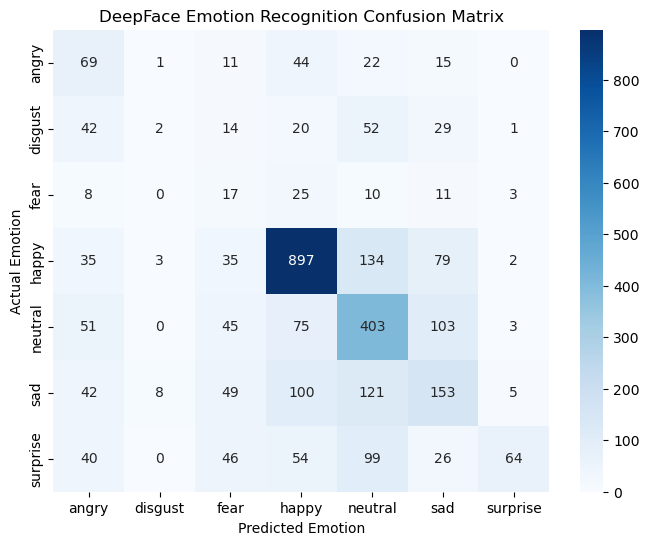

In [8]:
cm = confusion_matrix(df['True Emotion'], df['Predicted Emotion'], labels=df['True Emotion'].unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['True Emotion'].unique(), yticklabels=df['True Emotion'].unique())
plt.xlabel("Predicted Emotion")
plt.ylabel("Actual Emotion")
plt.title("DeepFace Emotion Recognition Confusion Matrix")
plt.show()

### Improve Accuracy - ResNet-50

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [13]:
# Path to the RAF dataset
data_dir = "rafdb_dataset_restructured/"  # Change this to your dataset path

# Create image generators for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation"
)

# Check class indices (mapping)
print(train_generator.class_indices)

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [15]:
# Load pre-trained ResNet-50 (without top layers)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

# Add custom layers for emotion classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(7, activation="softmax")(x)  # 7 emotion classes

# Create model
model = Model(inputs=base_model.input, outputs=output)

# Freeze initial layers of ResNet-50 to keep pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [17]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # Change from "grayscale" to "rgb"
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # Change from "grayscale" to "rgb"
    class_mode="categorical",
    subset="validation"
)

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.


In [18]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/25
154/154 [==============================] - 165s 1s/step - loss: 1.8522 - accuracy: 0.3718 - val_loss: 1.6877 - val_accuracy: 0.2227
Epoch 2/25
154/154 [==============================] - 154s 1s/step - loss: 1.5599 - accuracy: 0.4259 - val_loss: 1.9435 - val_accuracy: 0.2121
Epoch 3/25
154/154 [==============================] - 148s 960ms/step - loss: 1.4747 - accuracy: 0.4514 - val_loss: 1.5863 - val_accuracy: 0.4327
Epoch 4/25
154/154 [==============================] - 155s 1s/step - loss: 1.4315 - accuracy: 0.4603 - val_loss: 2.2326 - val_accuracy: 0.3874
Epoch 5/25
154/154 [==============================] - 138s 897ms/step - loss: 1.3920 - accuracy: 0.4768 - val_loss: 2.7708 - val_accuracy: 0.3968
Epoch 6/25
154/154 [==============================] - 162s 1s/step - loss: 1.3748 - accuracy: 0.4866 - val_loss: 1.8048 - val_accuracy: 0.3303
Epoch 7/25
154/154 [==============================] - 162s 1s/step - loss: 1.3506 - accuracy: 0.4947 - val_loss: 4.8715 - val_accuracy: 

In [20]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # 🔹 Convert grayscale to RGB
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # 🔹 Convert grayscale to RGB
    class_mode="categorical",
    subset="validation"
)


Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.


In [22]:
# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, "test"),
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # Ensure images are in RGB format
    class_mode="categorical"
)

# Evaluate accuracy
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Found 3068 images belonging to 7 classes.
48/48 [==============================] - 14s 293ms/step - loss: 1.7854 - accuracy: 0.4974
Test Accuracy: 49.74%


### Improve - Fine Tuned

In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

# Load ResNet-50 without the top layer
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

# Add classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(7, activation="softmax")(x)  # 7 emotion classes

# Create model
model = Model(inputs=base_model.input, outputs=output)

# Compile model (before fine-tuning)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Unfreeze Last 20 Layers & Fine-Tune

In [2]:
# Unfreeze last 20 layers of ResNet-50
for layer in base_model.layers[-20:]:  
    layer.trainable = True

# Recompile model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Print model summary to confirm trainable layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Reload Dataset

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the FER-2013 dataset
data_dir = "rafdb_dataset_restructured/"  # Change this to your dataset path

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    zoom_range=0.2,  
    horizontal_flip=True  
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # Convert grayscale to RGB
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # Convert grayscale to RGB
    class_mode="categorical",
    subset="validation"
)

# Check class mapping
print(train_generator.class_indices)

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


### Train the Model Again

In [4]:
# Train the fine-tuned model
history_finetune = model.fit(
    train_generator,
    epochs=35,  # Increase for better results
    validation_data=val_generator,
    verbose=1
)

Epoch 1/35
154/154 [==============================] - 497s 3s/step - loss: 2.7163 - accuracy: 0.2477 - val_loss: 344.6852 - val_accuracy: 0.1615
Epoch 2/35
154/154 [==============================] - 497s 3s/step - loss: 2.0310 - accuracy: 0.3524 - val_loss: 118.8637 - val_accuracy: 0.0575
Epoch 3/35
154/154 [==============================] - 479s 3s/step - loss: 1.7105 - accuracy: 0.4191 - val_loss: 36.2382 - val_accuracy: 0.2055
Epoch 4/35
154/154 [==============================] - 475s 3s/step - loss: 1.5625 - accuracy: 0.4632 - val_loss: 10.7736 - val_accuracy: 0.0559
Epoch 5/35
154/154 [==============================] - 447s 3s/step - loss: 1.4505 - accuracy: 0.5049 - val_loss: 2.3600 - val_accuracy: 0.3051
Epoch 6/35
154/154 [==============================] - 471s 3s/step - loss: 1.3538 - accuracy: 0.5386 - val_loss: 1.3509 - val_accuracy: 0.5400
Epoch 7/35
154/154 [==============================] - 458s 3s/step - loss: 1.2693 - accuracy: 0.5661 - val_loss: 1.1582 - val_accuracy: 

In [6]:
# Reload test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, "test"),  # Ensure test images are in the correct folder
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # Ensure images are in RGB format
    class_mode="categorical"
)

# Print number of test images
print(f"Found {test_generator.samples} test images.")

Found 3068 images belonging to 7 classes.
Found 3068 test images.


In [7]:
# Evaluate fine-tuned model
loss, accuracy = model.evaluate(test_generator)
print(f"Fine-Tuned Model Test Accuracy: {accuracy * 100:.2f}%")

48/48 [==============================] - 19s 393ms/step - loss: 0.9921 - accuracy: 0.6920
Fine-Tuned Model Test Accuracy: 69.20%


In [9]:
# Save the fine-tuned model
model.save("resnet50_emotion_model.h5")
print("Model saved successfully!")

S:\anaconda3\envs\deepface_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


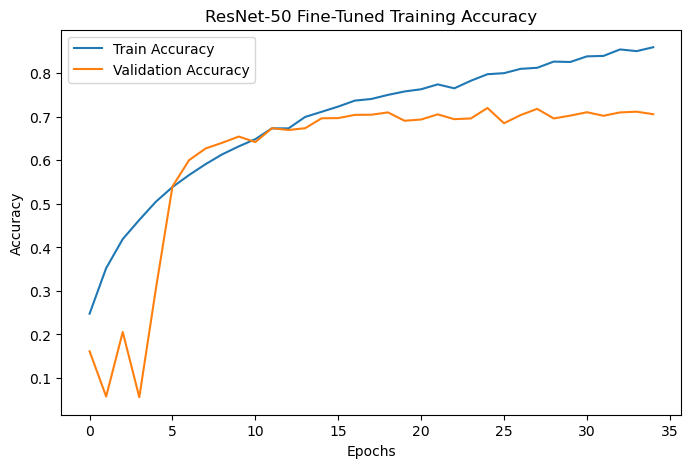

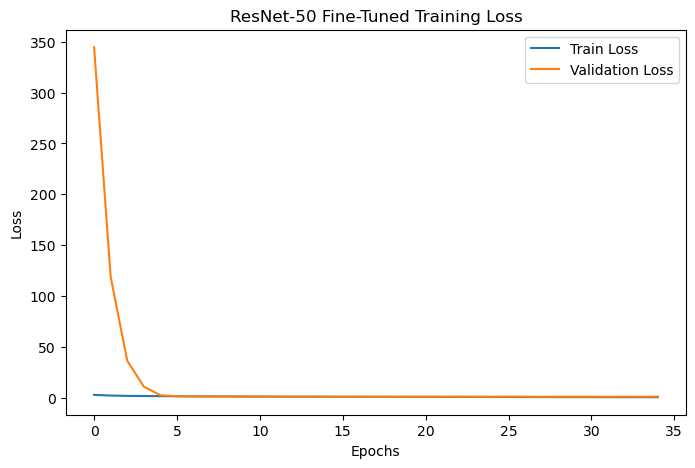

In [8]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet-50 Fine-Tuned Training Accuracy")
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("ResNet-50 Fine-Tuned Training Loss")
plt.show()

2/2 [==============================] - 2s 183ms/step


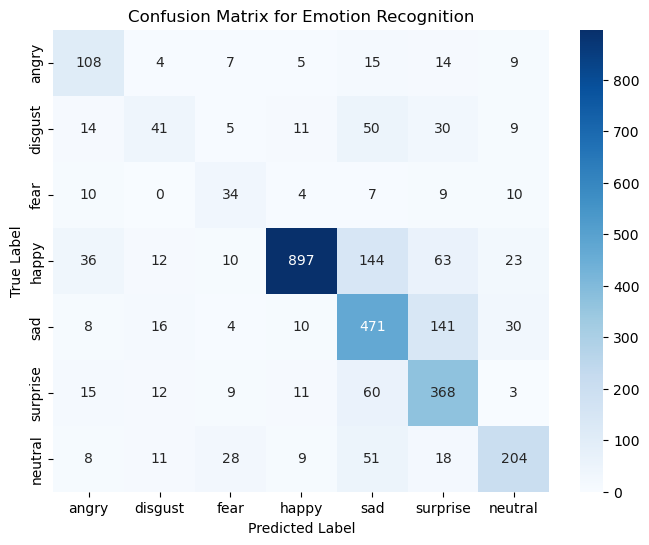

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels & predicted labels from the test set
true_labels = []
pred_labels = []

# Make predictions on the entire test dataset
for i in range(len(test_generator)):
    images, labels = test_generator[i]  # Get images & labels batch
    preds = model.predict(images)  # Predict emotions
    true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot to class indices
    pred_labels.extend(np.argmax(preds, axis=1))  # Convert softmax outputs to class indices

# Define emotion categories
emotion_classes = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Emotion Recognition")
plt.show()